In [23]:
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import torch

# 创建数据库引擎
database_url = "sqlite:///../data/data.sqlite"
engine = create_engine(database_url)

# define hyper paras
use_standard_scaler = True
save_imputed_data = False
notebook_mode = 'train'
device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

model_name = 'TransformerLSTM'
saved_table = 'sh_customs_daily_pred'
version = '0.5.0'

In [2]:
def plot_time_series(df, title='Time Series Data', xlabel='Date', ylabel='Value', figsize=(10, 6)):
    """
    绘制一个或多个时序数据的函数。
    
    参数:
    - df: 一个pandas DataFrame，索引为日期时间类型，每一列是一个时间序列。
    - title: 图表的标题。
    - xlabel: x轴的标签。
    - ylabel: y轴的标签。
    - figsize: 图表的尺寸，以英寸为单位。
    """
    plt.figure(figsize=figsize)
    for column in df.columns:
        plt.plot(df.index, df[column], label=column)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

query = "select global_entry,hkmo_entry,tw_entry from sh_customs_daily_imputed"
data = pd.read_sql_query(query, engine).astype('float')
original_data = data.copy()

Data Minmax Scaler

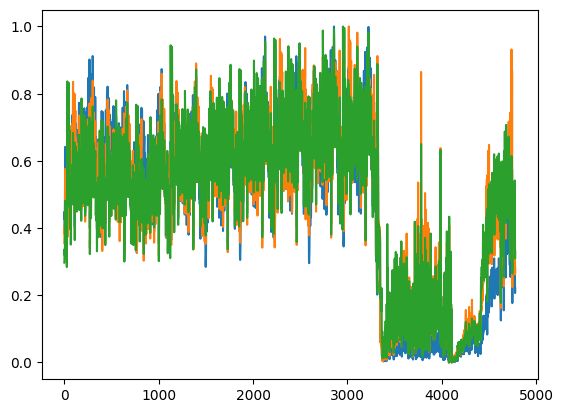

In [3]:
from sklearn.preprocessing import MinMaxScaler

scalers = {}

for column in data.columns:
    if column not in ['date']:
        scaler = MinMaxScaler()
        data[column] = scaler.fit_transform(data[column].values.reshape(-1, 1)).reshape(
            -1)
        scalers[column] = scaler

plt.plot(data)
plt.show()

valid == train


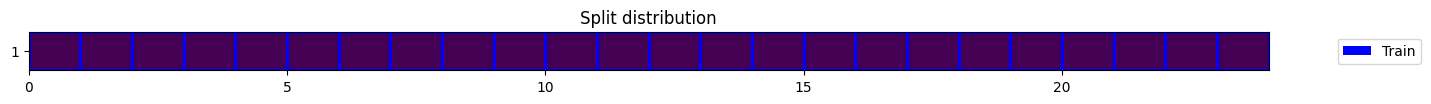

((24, 3, 360), (24, 3, 180))

In [4]:
from tsai.data.core import TSDatasets, TSDataLoaders
from tsai.data.validation import get_splits
from tsai.data.preparation import SlidingWindow
from tsai.data.core import TSForecasting

window_length = 360
stride = horizon = 180  # window move only one step forward, also means len(X)=len(data)
n_vars = 3

X, y = SlidingWindow(window_length, stride=stride, horizon=horizon, get_x=None, get_y=None)(data.values)
splits = get_splits(y, valid_size=0., stratify=False, random_state=42, shuffle=True)
dsets = TSDatasets(X, y, tfms=[None, [TSForecasting()]], splits=splits, inplace=True)
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid)
(X.shape, y.shape)

# train the model (using TSAI sklearn like API)

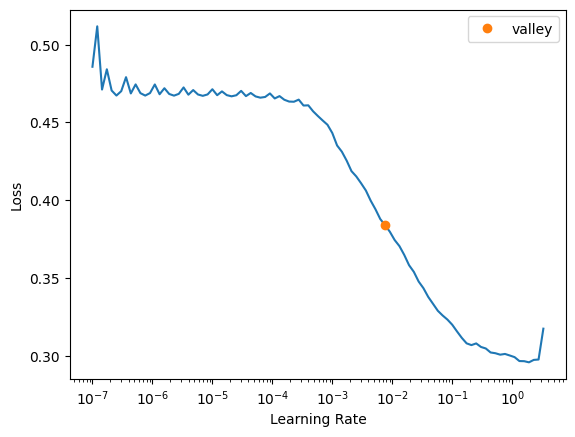

In [5]:
from torch.nn.functional import mse_loss
from tsai.data.core import TSForecasting
from tsai.tslearner import TSForecaster
from torch import nn
from tsai.callback.core import ShowGraphCallback2
from fastai.metrics import mae, rmse
from fastai.losses import MSELossFlat, L1LossFlat
from tsai.models.PatchTST import PatchTST
from tsai.models.TransformerRNNPlus import TransformerLSTMPlus

model = TransformerLSTMPlus(
    c_in=dls.vars,
    c_out=horizon * n_vars,
    seq_len=dls.len,
    proj_dropout= 0.05,
    nhead=32,
    num_rnn_layers=2,
    num_encoder_layers=1,
    dim_feedforward=2048,
    dropout=0.1,
    bidirectional=True,
)

# TODO: mae and rmse all need flatten check
learn = TSForecaster(
    X=X,
    y=y,
    splits=splits,
    tfms=[None, [TSForecasting()]],
    arch=model,
    batch_size=4,
    shuffle_train=False,
    device=device,
    loss_func=L1LossFlat(),
    metrics=[rmse], cbs=ShowGraphCallback2(),
    model_dir="../models"
)
if notebook_mode == 'train':
    learn.lr_find()

epoch,train_loss,valid_loss,_rmse,time


epoch,train_loss,valid_loss,_rmse,time
0,0.465179,0.462734,0.526722,00:00
1,0.462447,0.457342,0.521729,00:00
2,0.459531,0.451589,0.516349,00:00
3,0.456354,0.445247,0.510316,00:00
4,0.452828,0.438027,0.503316,00:00
5,0.448854,0.429635,0.494960,00:00
6,0.444301,0.419695,0.484761,00:00
7,0.439014,0.407850,0.472112,00:00
8,0.432823,0.393711,0.456275,00:00
9,0.425540,0.376837,0.436369,00:00


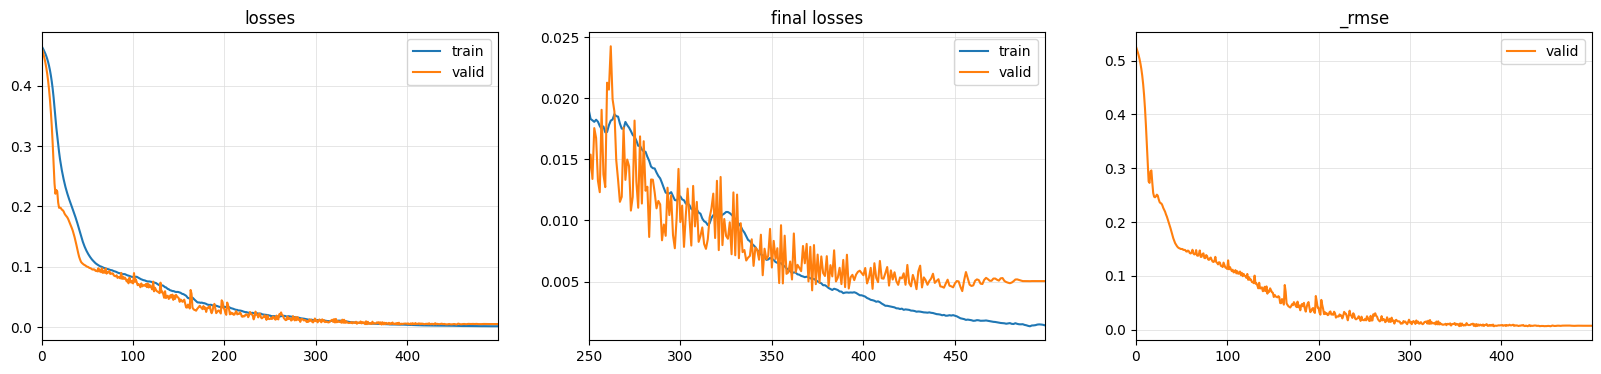

In [6]:
if notebook_mode == 'train':
    learn.fit_one_cycle(500, lr_max=1e-3)

In [24]:
import datetime

file_name = f"{model_name}_{saved_table}_{version}.pth"

if notebook_mode == 'train':
    torch.save(learn.model, f"../models/{file_name}", pickle_protocol=2)
    model = learn.model
    model.eval()
elif notebook_mode == 'predict':
    model = torch.load(f'../models/{file_name}', map_location=device)
    model.eval()

model

TransformerLSTMPlus(
  (backbone): _TransformerRNNEncoder(
    (proj_linear): Linear(in_features=3, out_features=128, bias=True)
    (proj_dropout): Dropout(p=0.05, inplace=False)
    (enc_layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
    (rnn_layers): ModuleList(
      (0): LSTM(128, 128, bidirectional=True)
      (1): LSTM(256, 256, bidirectional=True)
    )
  )
  (head): lin_nd_hea

In [20]:
import numpy as np

# 单步多次预测
predict_len = 2
pred = []
val = data.values
step = val[-window_length:]
with torch.no_grad():
    for _ in range(predict_len):
        p = torch.from_numpy(step.reshape(-1, dls.vars, dls.len)).type(torch.float).to(device=device)
        p_node = model(p)
        p_node = p_node.cpu().numpy().reshape(horizon, -1)
        step = np.append(step, p_node, axis=0)
        step = step[horizon:, :]
        pred.append(p_node)

pred = np.array(pred)
pred = pd.DataFrame(pred.reshape(-1, dls.vars), columns=data.columns)
for column in pred.columns:
    shape = pred[column].values.shape
    pred[column] = scalers[column].inverse_transform(pred[column].values.reshape(shape[0], -1))

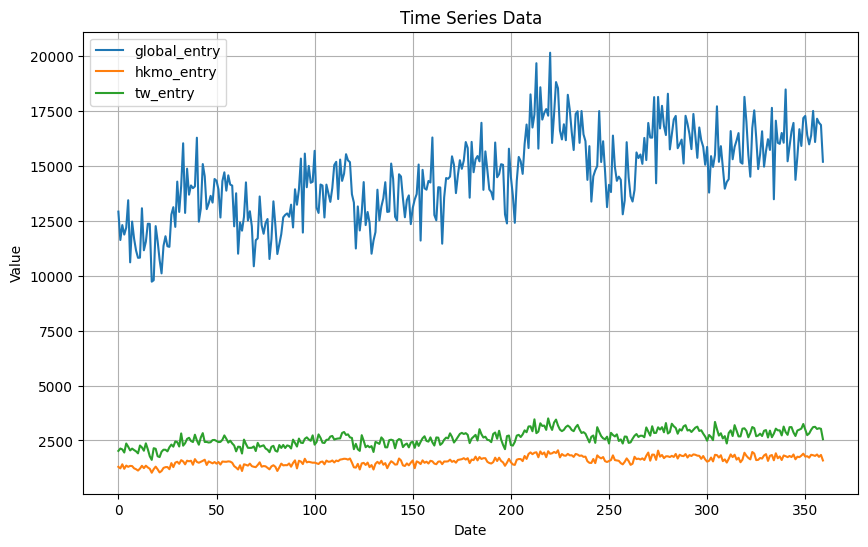

In [21]:
plot_time_series(pred)

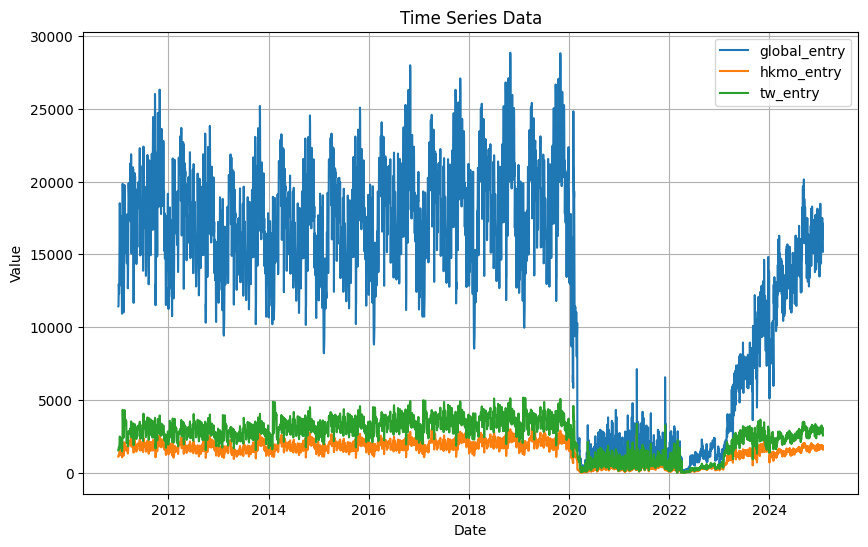

In [22]:
pred_data = pd.DataFrame(np.append(original_data.values, pred, axis=0), columns=original_data.columns)
pred_data.index = pd.date_range(start="2011-01-01", periods=pred_data.shape[0])
plot_time_series(pred_data)

In [11]:
pred_data.to_sql('sh_customs_daily_pred', con=engine, if_exists='replace', index=True)

5139